In [1]:
import SPARQLWrapper

sparql = SPARQLWrapper.SPARQLWrapper("https://query.wikidata.org/sparql")

query = '''
PREFIX target: <http://www.wikidata.org/entity/Q41112>

SELECT
  ?count
  ?gene_count
  ?symptom_count
  ?disease ?diseaseLabel
  ?genes
  ?symptoms
{
  {
    SELECT ?disease (COUNT(?gene) AS ?gene_count) (GROUP_CONCAT(?gene_label; separator=" // ") AS ?genes) WHERE {
      target: wdt:P2293 ?gene .
      ?gene wdt:P2293 ?disease .
      FILTER (target: != ?disease)
      ?gene rdfs:label ?gene_label
      FILTER(lang(?gene_label) = "en")
    }
    GROUP BY ?disease
  }
  UNION
  {
    SELECT
      ?disease (COUNT(?symptom) AS ?symptom_count) (GROUP_CONCAT(?symptom_label; separator=" // ") AS ?symptoms)
    {
      target: wdt:P780 ?symptom .
      ?disease wdt:P780 ?symptom .
      FILTER (target: != ?disease)
      ?symptom rdfs:label ?symptom_label . FILTER(lang(?symptom_label) = "en")
    }
    GROUP BY ?disease
  }

  # Aggregate count
  BIND((COALESCE(?symptom_count, 0) + COALESCE(?gene_count, 0)) AS ?count)

  SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
}
ORDER BY DESC(?count)
'''

# Set the query language to SPARQL
sparql.setQuery(query)

# Set the return format to JSON
sparql.setReturnFormat(SPARQLWrapper.JSON)

# Execute the query and store the results
results = sparql.query().convert()


In [ ]:
for disease in results['results']['bindings']:
    for key, value in disease.items():
        print(key)
        print(value['value'])

In [2]:
reformatted_dict = {}

entities = []
result_list = results['results']['bindings']
for res in result_list:
    for res_key, res_value in res.items():
        if res_key == 'disease':
            uri = res_value['value']
            splitted_uri = uri.split('/')
            entity_id = splitted_uri[-1]
            entities.append(entity_id)
            reformatted_dict[entity_id] = res

print(reformatted_dict)

{'Q131755': {'disease': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q131755'}, 'diseaseLabel': {'xml:lang': 'en', 'type': 'literal', 'value': 'bipolar disorder'}, 'count': {'datatype': 'http://www.w3.org/2001/XMLSchema#integer', 'type': 'literal', 'value': '14'}, 'gene_count': {'datatype': 'http://www.w3.org/2001/XMLSchema#integer', 'type': 'literal', 'value': '14'}, 'genes': {'type': 'literal', 'value': 'NPAS3 // CACNA1C // MSRA // PTPRN2 // IFT88 // ANK3 // KCNMB2 // PHF8 // CNTNAP2 // ERC2 // COMMD10 // RIN2 // NLRC5 // MYO18B'}}, 'Q12174': {'disease': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q12174'}, 'diseaseLabel': {'xml:lang': 'en', 'type': 'literal', 'value': 'obesity'}, 'count': {'datatype': 'http://www.w3.org/2001/XMLSchema#integer', 'type': 'literal', 'value': '5'}, 'gene_count': {'datatype': 'http://www.w3.org/2001/XMLSchema#integer', 'type': 'literal', 'value': '5'}, 'genes': {'type': 'literal', 'value': 'PTPRN2 // CNTNAP2 // CTNNA3 // RIN2 // 

In [3]:
import pandas as pd

df = pd.DataFrame.from_dict(reformatted_dict)
df = df.transpose()

print(df.columns)
print(df)

Index(['disease', 'diseaseLabel', 'count', 'gene_count', 'genes',
       'symptom_count', 'symptoms'],
      dtype='object')
                                                     disease  \
Q131755    {'type': 'uri', 'value': 'http://www.wikidata....   
Q12174     {'type': 'uri', 'value': 'http://www.wikidata....   
Q4340209   {'type': 'uri', 'value': 'http://www.wikidata....   
Q11081     {'type': 'uri', 'value': 'http://www.wikidata....   
Q520127    {'type': 'uri', 'value': 'http://www.wikidata....   
Q35869     {'type': 'uri', 'value': 'http://www.wikidata....   
Q55950055  {'type': 'uri', 'value': 'http://www.wikidata....   
Q42844     {'type': 'uri', 'value': 'http://www.wikidata....   
Q844935    {'type': 'uri', 'value': 'http://www.wikidata....   
Q206901    {'type': 'uri', 'value': 'http://www.wikidata....   
Q9051491   {'type': 'uri', 'value': 'http://www.wikidata....   
Q8277      {'type': 'uri', 'value': 'http://www.wikidata....   
Q49000071  {'type': 'uri', 'value': 'http:/

In [5]:
schizophrenia_gene_associations = ['CACNA1C', 'TSNARE1', 'SLCO6A1', 'ZEB2', 'SDCCAG8', 'NOTCH4', 'BRD1', 'FBXO11', 'ARHGAP31', 'POM121L2', 'NKAIN2', 'TCF4', 'ARNTL', 'CDH13', 'CTNNA3', 'BCL9', 'ZFYVE28', 'RORA', 'KIF26B', 'NLRC5', 'HHAT', 'PPFIA2', 'CNTNAP5', 'TMTC1', 'KCNMB2', 'MSRA', 'COMMD10', 'CSMD1', 'NFKB1', 'TSPAN18', 'CNNM2', 'NT5C2', 'STT3A', 'TRIM26', 'ERC2', 'PTPRN2', 'PHF8', 'RIN2', 'CNTNAP2', 'MYO18B', 'IFT88', 'NPAS3', 'PLAA', 'ACSM1', 'ANK3', 'VRK2', 'TNIK', 'TRAF3', 'ZNF804A', 'AGBL1', 'CCDC60', 'RELN', 'APOL2', 'CACNA1G', 'STAG1', 'FAM120A', 'SETD1A', 'SP4', 'TRIO', 'AKAP11', 'GRIA3']

for index, row in df.iterrows():
    # print(row['genes'])
    genes = row['genes']
    if isinstance(genes, dict) :
        value = genes['value']
        value = value.split('//')
        # print(value)

        matching_genes = [i for i, j in zip(value, schizophrenia_gene_associations) if i == j]
        print(matching_genes)




[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['CACNA1C']
['CACNA1C']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


In [14]:
# symptoms and signs
schizophrenia_symptoms = ['cognitive dysfunction', 'psychosis']

for i, j in df.iterrows():
    symptoms = j['symptoms']
    if isinstance(symptoms, dict) :
        symptoms = symptoms['value'].split('//')
        #print(symptoms)

        matching_symptoms = [a for a, b in zip(symptoms, schizophrenia_symptoms) if a == b]
    print(matching_symptoms)

['psychosis']
['psychosis']
['psychosis']
['psychosis']
['psychosis']
['psychosis']
['psychosis']
['psychosis']
['psychosis']
['psychosis']
['psychosis']
['psychosis']
['cognitive dysfunction']
['cognitive dysfunction']
['cognitive dysfunction']
['cognitive dysfunction']
['cognitive dysfunction']
['cognitive dysfunction']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


In [41]:
schizophrenia_gene_associations = ['CACNA1C', 'TSNARE1', 'SLCO6A1', 'ZEB2', 'SDCCAG8', 'NOTCH4', 'BRD1', 'FBXO11', 'ARHGAP31', 'POM121L2', 'NKAIN2', 'TCF4', 'ARNTL', 'CDH13', 'CTNNA3', 'BCL9', 'ZFYVE28', 'RORA', 'KIF26B', 'NLRC5', 'HHAT', 'PPFIA2', 'CNTNAP5', 'TMTC1', 'KCNMB2', 'MSRA', 'COMMD10', 'CSMD1', 'NFKB1', 'TSPAN18', 'CNNM2', 'NT5C2', 'STT3A', 'TRIM26', 'ERC2', 'PTPRN2', 'PHF8', 'RIN2', 'CNTNAP2', 'MYO18B', 'IFT88', 'NPAS3', 'PLAA', 'ACSM1', 'ANK3', 'VRK2', 'TNIK', 'TRAF3', 'ZNF804A', 'AGBL1', 'CCDC60', 'RELN', 'APOL2', 'CACNA1G', 'STAG1', 'FAM120A', 'SETD1A', 'SP4', 'TRIO', 'AKAP11', 'GRIA3']
schizophrenia_symptoms = ['psychosis', 'cognitive dysfunction']


# iterate over dataframe
for index, row in df.iterrows():

    # matching genes
    genes = row['genes']
    if isinstance(genes, dict) :
        genes = genes['value'].split('//')
        matching_genes = [a for a, b in zip(genes, schizophrenia_gene_associations) if a == b]
        print(matching_genes)
        matching_genes_count = len(matching_genes)
        print(matching_genes_count)

    else:
        matching_genes_count = 0
    # matching symptoms
    symptoms = j['symptoms']
    if isinstance(symptoms, dict) :
        symptoms = symptoms['value'].split('//')
        matching_symptoms = [a for a, b in zip(symptoms, schizophrenia_symptoms) if a == b]
        # print(matching_symptoms)
        matching_symptoms_count = len(matching_symptoms_count)
        # print(matching_symptoms_count)

    else:
        matching_symptoms_count = 0

    similarities = matching_genes_count + matching_symptoms_count
    print(similarities)
    df['similarities'] = similarities




[]
0
0
[]
0
0
[]
0
0
[]
0
0
[]
0
0
[]
0
0
[]
0
0
[]
0
0
[]
0
0
[]
0
0
[]
0
0
[]
0
0
0
0
0
0
0
0
0
0
0
0
0
[]
0
0
[]
0
0
[]
0
0
[]
0
0
[]
0
0
[]
0
0
[]
0
0
[]
0
0
[]
0
0
[]
0
0
[]
0
0
[]
0
0
[]
0
0
[]
0
0
[]
0
0
[]
0
0
[]
0
0
[]
0
0
[]
0
0
[]
0
0
[]
0
0
[]
0
0
[]
0
0
[]
0
0
[]
0
0
[]
0
0
[]
0
0
[]
0
0
[]
0
0
['CACNA1C']
1
1
['CACNA1C']
1
1
[]
0
0
[]
0
0
[]
0
0
[]
0
0
[]
0
0
[]
0
0


In [34]:
print(df['similarities'])

Q131755      0
Q12174       0
Q4340209     0
Q11081       0
Q520127      0
Q35869       0
Q55950055    0
Q42844       0
Q844935      0
Q206901      0
Q9051491     0
Q8277        0
Q49000071    0
Q18558272    0
Q3234995     0
Q3065932     0
Q2728811     0
Q917357      0
Q84263196    0
Q21175356    0
Q21175349    0
Q3964296     0
Q160796      0
Q11088       0
Q55784933    0
Q32136733    0
Q1198391     0
Q55783958    0
Q28065616    0
Q32143061    0
Q12214       0
Q27674842    0
Q53660491    0
Q18553852    0
Q55345906    0
Q27164447    0
Q18553444    0
Q133772      0
Q168403      0
Q28065627    0
Q2757585     0
Q1164529     0
Q55784936    0
Q181923      0
Q5340515     0
Q830308      0
Q180913      0
Q41861       0
Q18554727    0
Q1464888     0
Q1164401     0
Q1477        0
Q27677684    0
Q3508705     0
Q50349648    0
Q18553536    0
Q945238      0
Q3589154     0
Q756610      0
Q130555      0
Name: similarities, dtype: int64


In [ ]:

schizophrenia_gene_associations = ['CACNA1C', 'TSNARE1', 'SLCO6A1', 'ZEB2', 'SDCCAG8', 'NOTCH4', 'BRD1', 'FBXO11', 'ARHGAP31', 'POM121L2', 'NKAIN2', 'TCF4', 'ARNTL', 'CDH13', 'CTNNA3', 'BCL9', 'ZFYVE28', 'RORA', 'KIF26B', 'NLRC5', 'HHAT', 'PPFIA2', 'CNTNAP5', 'TMTC1', 'KCNMB2', 'MSRA', 'COMMD10', 'CSMD1', 'NFKB1', 'TSPAN18', 'CNNM2', 'NT5C2', 'STT3A', 'TRIM26', 'ERC2', 'PTPRN2', 'PHF8', 'RIN2', 'CNTNAP2', 'MYO18B', 'IFT88', 'NPAS3', 'PLAA', 'ACSM1', 'ANK3', 'VRK2', 'TNIK', 'TRAF3', 'ZNF804A', 'AGBL1', 'CCDC60', 'RELN', 'APOL2', 'CACNA1G', 'STAG1', 'FAM120A', 'SETD1A', 'SP4', 'TRIO', 'AKAP11', 'GRIA3']
schizophrenia_symptoms = ['psychosis', 'cognitive dysfunction']


# iterate over dataframe
for index, row in df.iterrows():

    # matching genes
    genes = row['genes']

    if isinstance(genes, dict) :
        genes = genes['value'].split('//')
        matching_genes = [a for a, b in zip(genes, schizophrenia_gene_associations) if a == b]
        matching_genes_count = len(matching_genes)

    else:
        matching_genes_count = 0

    # matching symptoms
    symptoms = row['symptoms']


    if isinstance(symptoms, dict) :
        symptoms = symptoms['value'].split('//')
        matching_symptoms = [i for i, j in zip(symptoms, schizophrenia_symptoms) if i == j]
        matching_symptoms_count = len(matching_symptoms_count)

    else:
        matching_symptoms_count = 0



    similarities = matching_genes_count + matching_symptoms_count
    print(similarities)
    df['similarities'] = similarities



0


KeyboardInterrupt: 

In [4]:
import pycircos
import matplotlib.pyplot as plt
Tarc    = pycircos.Tarc
Tcircle = pycircos.Tcircle

In [5]:
Garc    = pycircos.Garc
Gcircle = pycircos.Gcircle



In [6]:
# get instance of class Gcircle
circle = Gcircle(figsize=(8,8))


<Figure size 576x576 with 0 Axes>

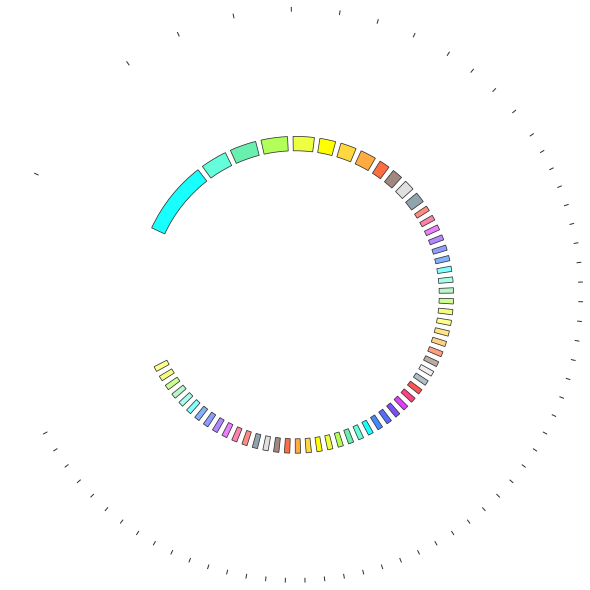

In [8]:
for index, row in df.iterrows():
    size = int(row['count']['value'])
    arc = Garc(arc_id=index, size=size, interspace=2) # , label_visible=True) # interspace=50, raxis_range=(935,935), label_visible=True)# , size=size)
    circle.add_garc(arc)


circle.set_garcs(-65,245)

for arc_id in circle.garc_dict:
    circle.tickplot(arc_id, raxis_range=(985,1000), tickinterval=20000000)

circle.figure

In [98]:
circle1 = Gcircle(figsize=(8,8))

<Figure size 576x576 with 0 Axes>

In [99]:
for index, row in df.iterrows():
    size = int(row['count']['value'])
    arc1 = Garc(arc_id=index, size=size, interspace=2) # , label_visible=True) # interspace=50, raxis_range=(935,935), label_visible=True)# , size=size)
    circle1.add_garc(arc)


circle1.figure


<Figure size 576x576 with 0 Axes>